In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap

In [2]:
class ScratchDecisionTreeClassifierDepth1:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.left_class = None
        self.right_class = None

    def calculate_gini_impurity(self, samples_per_class):
        total_samples = sum(samples_per_class)
        num_classes = len(samples_per_class)

        if total_samples == 0:
            return 0

        gini_impurity = 1.0

        for i in range(num_classes):
            proportion = samples_per_class[i] / total_samples
            gini_impurity -= proportion ** 2

        return gini_impurity

    def calculate_information_gain(self, gini_parent, samples_left, samples_right):
        total_samples_left = sum(samples_left)
        total_samples_right = sum(samples_right)
        total_samples_parent = total_samples_left + total_samples_right

        if total_samples_parent == 0:
            return 0

        proportion_left = total_samples_left / total_samples_parent
        proportion_right = total_samples_right / total_samples_parent

        gini_left = self.calculate_gini_impurity(samples_left)
        gini_right = self.calculate_gini_impurity(samples_right)

        information_gain = gini_parent - (proportion_left * gini_left + proportion_right * gini_right)

        return information_gain

    def find_best_split(self, X, y):
        num_samples, num_features = X.shape
        if num_samples <= 1:
            return None, None, None, None  # Don't split if only one sample or empty node

        classes = list(set(y))
        gini_parent = self.calculate_gini_impurity([list(y).count(c) for c in classes])
        best_info_gain = 0
        best_feature = None
        best_threshold = None

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            unique_values = set(feature_values)

            for threshold in unique_values:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask

                samples_left = [list(y[left_mask]).count(c) for c in classes]
                samples_right = [list(y[right_mask]).count(c) for c in classes]

                info_gain = self.calculate_information_gain(gini_parent, samples_left, samples_right)

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold, best_info_gain, gini_parent

    def fit(self, X, y):
        best_feature, best_threshold, _, _ = self.find_best_split(X, y)

        if best_feature is not None:
            self.feature_index = best_feature
            self.threshold = best_threshold

            left_mask = X[:, best_feature] <= best_threshold
            right_mask = ~left_mask

            self.left_class = max(set(y[left_mask]), key=list(y[left_mask]).count)
            self.right_class = max(set(y[right_mask]), key=list(y[right_mask]).count)

    def predict_sample(self, sample):
        if self.feature_index is not None and self.threshold is not None:
            if sample[self.feature_index] <= self.threshold:
                return self.left_class
            else:
                return self.right_class
        else:
            raise ValueError("The model has not been trained yet. Call 'fit' first.")

    def predict(self, X):
        return [self.predict_sample(sample) for sample in X]

In [3]:
class ScratchDecisionTreeClassifierDepthInf:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left_class = None
        self.right_class = None
        self.left_tree = None
        self.right_tree = None

    def calculate_gini_impurity(self, samples_per_class):
        total_samples = sum(samples_per_class)
        num_classes = len(samples_per_class)

        if total_samples == 0:
            return 0

        gini_impurity = 1.0

        for i in range(num_classes):
            proportion = samples_per_class[i] / total_samples
            gini_impurity -= proportion ** 2

        return gini_impurity

    def calculate_information_gain(self, gini_parent, samples_left, samples_right):
        total_samples_left = sum(samples_left)
        total_samples_right = sum(samples_right)
        total_samples_parent = total_samples_left + total_samples_right

        if total_samples_parent == 0:
            return 0

        proportion_left = total_samples_left / total_samples_parent
        proportion_right = total_samples_right / total_samples_parent

        gini_left = self.calculate_gini_impurity(samples_left)
        gini_right = self.calculate_gini_impurity(samples_right)

        information_gain = gini_parent - (proportion_left * gini_left + proportion_right * gini_right)

        return information_gain

    def find_best_split(self, X, y):
        num_samples, num_features = X.shape
        if num_samples <= 1:
            return None, None, None, None  # Don't split if only one sample or empty node

        classes = list(set(y))
        gini_parent = self.calculate_gini_impurity([list(y).count(c) for c in classes])
        best_info_gain = 0
        best_feature = None
        best_threshold = None

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            unique_values = set(feature_values)

            for threshold in unique_values:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask

                samples_left = [list(y[left_mask]).count(c) for c in classes]
                samples_right = [list(y[right_mask]).count(c) for c in classes]

                info_gain = self.calculate_information_gain(gini_parent, samples_left, samples_right)

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature = feature_index
                    best_threshold = threshold

        return best_feature, best_threshold, best_info_gain, gini_parent

    def fit(self, X, y, depth=1):
        if (self.max_depth is not None and depth == self.max_depth) or len(set(y)) == 1:
            # If the tree reaches the specified depth or the node is pure, create a leaf node
            self.left_class = max(set(y), key=list(y).count)
            self.right_class = max(set(y), key=list(y).count)
            return

        best_feature, best_threshold, _, _ = self.find_best_split(X, y)

        if best_feature is not None:
            self.feature_index = best_feature
            self.threshold = best_threshold

            left_mask = X[:, best_feature] <= best_threshold
            right_mask = ~left_mask

            self.left_tree = ScratchDecisionTreeClassifierDepthInf(max_depth=self.max_depth)
            self.left_tree.fit(X[left_mask, :], y[left_mask], depth + 1)

            self.right_tree = ScratchDecisionTreeClassifierDepthInf(max_depth=self.max_depth)
            self.right_tree.fit(X[right_mask, :], y[right_mask], depth + 1)

    def predict_sample(self, sample):
        if self.feature_index is not None and self.threshold is not None:
            if sample[self.feature_index] <= self.threshold:
                return self.left_tree.predict_sample(sample)
            else:
                return self.right_tree.predict_sample(sample)
        else:
            raise ValueError("The model has not been trained yet. Call 'fit' first.")

    def predict(self, X):
        return [self.predict_sample(sample) for sample in X]

In [4]:
# Create a simple dataset for binary classification
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=2, n_redundant=0, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Train the scratch decision tree classifier
scratch_tree = ScratchDecisionTreeClassifierDepth1()
scratch_tree.fit(X_train, y_train)

# Make predictions using the scratch decision tree
scratch_predictions = scratch_tree.predict(X_test)

# Train the scikit-learn decision tree classifier
sklearn_tree = DecisionTreeClassifier(max_depth=1, random_state=42)
sklearn_tree.fit(X_train, y_train)

# Make predictions using the scikit-learn decision tree
sklearn_predictions = sklearn_tree.predict(X_test)

# Compare predictions
print("Scratch Predictions:", scratch_predictions)
print("Scikit-learn Predictions:", sklearn_predictions)

Scratch Predictions: [0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Scikit-learn Predictions: [0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0]


In [6]:
# Evaluate performance using scikit-learn metrics
accuracy_scratch = accuracy_score(y_test, scratch_predictions)
precision_scratch = precision_score(y_test, scratch_predictions)
recall_scratch = recall_score(y_test, scratch_predictions)

accuracy_sklearn = accuracy_score(y_test, sklearn_predictions)
precision_sklearn = precision_score(y_test, sklearn_predictions)
recall_sklearn = recall_score(y_test, sklearn_predictions)

print("\nPerformance Metrics:")
print("Scratch Decision Tree - Accuracy:", accuracy_scratch)
print("Scratch Decision Tree - Precision:", precision_scratch)
print("Scratch Decision Tree - Recall:", recall_scratch)

print("\nScikit-learn Decision Tree - Accuracy:", accuracy_sklearn)
print("Scikit-learn Decision Tree - Precision:", precision_sklearn)
print("Scikit-learn Decision Tree - Recall:", recall_sklearn)


Performance Metrics:
Scratch Decision Tree - Accuracy: 0.95
Scratch Decision Tree - Precision: 0.9
Scratch Decision Tree - Recall: 1.0

Scikit-learn Decision Tree - Accuracy: 0.95
Scikit-learn Decision Tree - Precision: 0.9
Scikit-learn Decision Tree - Recall: 1.0


In [7]:
# Function to plot decision boundaries
def plot_decision_boundary(X, y, model, title):
    h = 0.02  # Step size in the mesh

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(Z).reshape(xx.shape)

    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

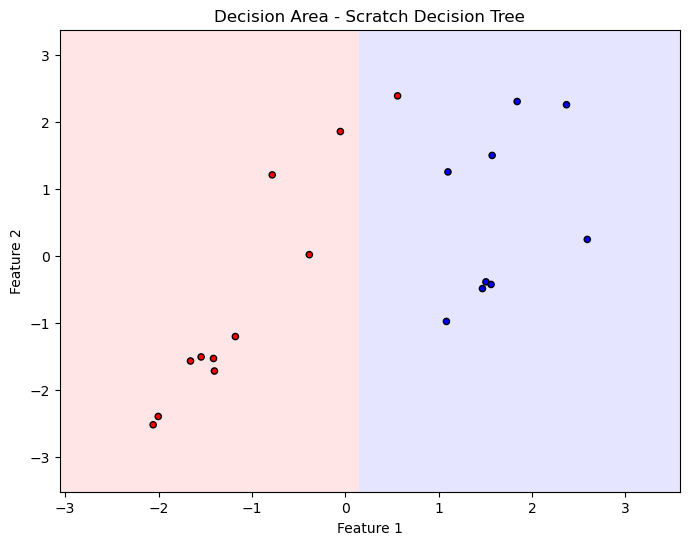

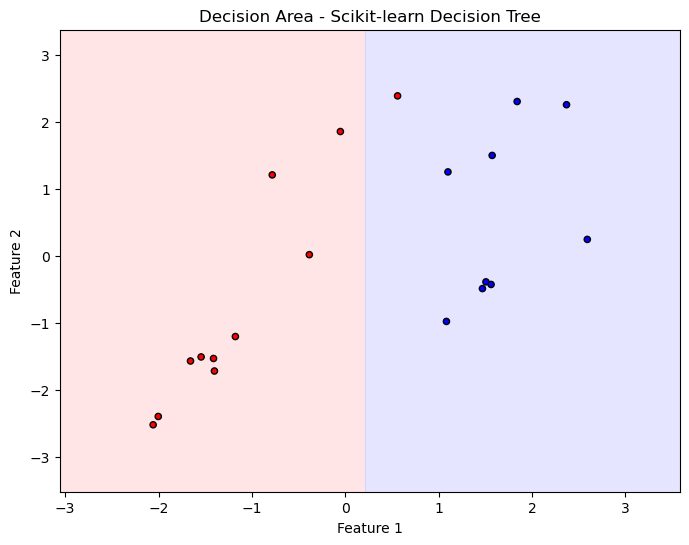

In [8]:
# Plot decision boundaries for scratch decision tree
plot_decision_boundary(X_test, y_test, scratch_tree, "Decision Area - Scratch Decision Tree")

# Plot decision boundaries for scikit-learn decision tree
plot_decision_boundary(X_test, y_test, sklearn_tree, "Decision Area - Scikit-learn Decision Tree")